# Control points optimization - differential evolution

In [30]:
from shapeOptInductor import gen_meshN, Id
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

## 1 - Geometry and meshing

We define a geometry with an arbitrary number of control points on the airgap.

In [31]:
NControlPoints = 10
airgap = [1e-3,2e-3]*(NControlPoints//2)
lz = 1e-2  # thickness in the z-direction (m)
s = 4  # symmetry factor

maxh = 4e-3
mesh = gen_meshN(airgap, maxh)

XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})

materialFunction = 1 * XiAir + 2 * XiCoil + 3 * XiCore
Draw(materialFunction, mesh, radius=0.02)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2 - State problem

### a) Parameters definition

In [32]:
f = 5e4  # working frequency (Hz)
omega = 2 * np.pi * f  # rad/s
mu0 = 4e-7 * np.pi  # void permeability (H/m)
mur = 1000  # relative permeability of iron (no unit)
mu_iron = mur * mu0  # permeability of iron (H/m)
delta = 0.1  # loss angle associated with the coil (rad)
mu_coil = np.exp(-1j * delta) * mu0  # complex permeability
nb_turn = 200  # number of turn in the coil (no unit)
Is = 2  # source current intensity (A)
js = nb_turn / 2 * Is / (ngs.Integrate(XiCoil, mesh)) * XiCoil  # source current density (A/m²)


### b) Definition of the magnetic problem

In [33]:
def magWeakFormComplex(a, a_):
    """Return the complex weak form of the magnetic problem, i.e, bilinear
    and linear forms (matrix and right-hand side after discretization, respectively)"""

    # bilinear form (transmission)
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")

    # linear form (source)
    lf = a_ * js * ngs.dx("coil")

    return bf, lf


def solveStateComplex(mesh):
    """Solve the complex magnetic state"""
    # definition of function space
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    a, a_ = fes.TnT()

    # definition of weak form
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf
    F += f

    # assembly
    K.Assemble()
    F.Assemble()

    # solving
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    gf.vec.data = Kinv * F.vec

    return gf


### c) Definition of the post-processed quantities

We define the losses and inductance. We don't need derivatives here since we'll use a differential evolution algorithm, which is a gradient-free optimization algorithm.

In [34]:
def Inductance(a, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (Is**2) * ngs.Integrate(rel.real * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def Losses(a, mesh):
    rel = XiCoil / mu_coil
    return s * np.pi * f * lz * ngs.Integrate(rel.imag * ngs.Norm(ngs.grad(a)) ** 2, mesh)


## 3 - Optimization

### a) Scipy wrapper
We first define wrappers of the objective function to minimize (the losses) and the constraint (the inductance value). We have to set a tolerance for the equality constraint, that we chose to be $\pm5\%$.

In [35]:
# FEM evaluation counter (solve the FEM system)
FEMcounter = [0]
LossList = []
xList = []

def scipyObj(x, maxh = 4e-3):
    """ Scipy wrapper to the objective function to minimize """
    FEMcounter[0] += 1                      # Increment at each evaluation
    if FEMcounter[0] % 100 == 0:            # print every 100 function calls
        print(f"{FEMcounter[0]} function evaluations")
    mesh = gen_meshN(list(x), maxh)
    a = solveStateComplex(mesh)
    return Losses(a, mesh)

def scipyConst(x, maxh = 4e-3):
    """ Scipy wrapper to the constraint to respect """
    FEMcounter[0] += 1                      # Increment at each evaluation
    if FEMcounter[0] % 100 == 0:            # print every 100 function calls
        print(f"Evaluation {FEMcounter[0]}")
    mesh = gen_meshN(list(x), maxh)
    a = solveStateComplex(mesh)
    return Inductance(a, mesh) - 1e-3

def callback(intermediate_result):
    LossList.append(intermediate_result.fun)
    xList.append(intermediate_result.x)


from scipy.optimize import NonlinearConstraint, Bounds
nlc = NonlinearConstraint(scipyConst,-5e-5,5e-5)
bnds = Bounds(5e-4*np.ones(NControlPoints), 7.2e-3*np.ones(NControlPoints))


### b) Optimization

We use `differential_evolution` from `scipy.optimize` package.

In [36]:
from scipy.optimize import differential_evolution

help(differential_evolution)

Help on function differential_evolution in module scipy.optimize._differentialevolution:

differential_evolution(
    func,
    bounds,
    args=(),
    strategy='best1bin',
    maxiter=1000,
    popsize=15,
    tol=0.01,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=None,
    callback=None,
    disp=False,
    polish=True,
    init='latinhypercube',
    atol=0,
    updating='immediate',
    workers=1,
    constraints=(),
    x0=None,
    *,
    integrality=None,
    vectorized=False
)
    Finds the global minimum of a multivariate function.

    The differential evolution method [1]_ is stochastic in nature. It does
    not use gradient methods to find the minimum, and can search large areas
    of candidate space, but often requires larger numbers of function
    evaluations than conventional gradient-based techniques.

    The algorithm is due to Storn and Price [2]_.

    Parameters
    ----------
    func : callable
        The objective function to be minimized. Must be 

In [ ]:
result = differential_evolution(
    scipyObj,
    bounds=bnds,
    maxiter=100,
    popsize=15,
    tol = 0.1,
    atol= 0.1,
    seed=0, # for reproducibility
    disp=True,
    polish=False,
    constraints = nlc,
)

Evaluation 100
Evaluation 200
Evaluation 300
differential_evolution step 1: f(x)= 5.1543575142646
Evaluation 400
Evaluation 500
differential_evolution step 2: f(x)= 5.1543575142646
Evaluation 600
differential_evolution step 3: f(x)= 5.1543575142646
Evaluation 700
Evaluation 800
differential_evolution step 4: f(x)= 5.1543575142646
Evaluation 900
Evaluation 1000
differential_evolution step 5: f(x)= 5.1543575142646
1100 function evaluations
differential_evolution step 6: f(x)= 5.1543575142646
Evaluation 1200
Evaluation 1300
differential_evolution step 7: f(x)= 5.044131729246609
1400 function evaluations
Evaluation 1500
differential_evolution step 8: f(x)= 4.994352612204958
Evaluation 1600
Evaluation 1700
differential_evolution step 9: f(x)= 4.994352612204958
Evaluation 1800
differential_evolution step 10: f(x)= 4.994352612204958
Evaluation 1900
Evaluation 2000
differential_evolution step 11: f(x)= 4.954416448451117
Evaluation 2100
Evaluation 2200
differential_evolution step 12: f(x)= 4.95

## 4) Results

### a) Design

In [ ]:
meshOpt = gen_meshN(result.x)
Draw(materialFunction, meshOpt, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

### b) Performance

In [ ]:
a = solveStateComplex(meshOpt)
print(f" Losses = {Losses(a, meshOpt) : .3f} W")
print(f" Inductance = {Inductance(a, meshOpt)*1000 : .3f} mH")
#loss
print("Number of objective function evaluations = ", result.nfev)
print("Number of FEM evaluations (objective + constraints) = ", FEMcounter[0])

 Losses =  5.097 W
 Inductance =  0.960 mH
Number of objective function evaluations =  462
Number of FEM evaluations (objective + constraints) =  2925


Text(0, 0.5, 'AC Losses (W)')

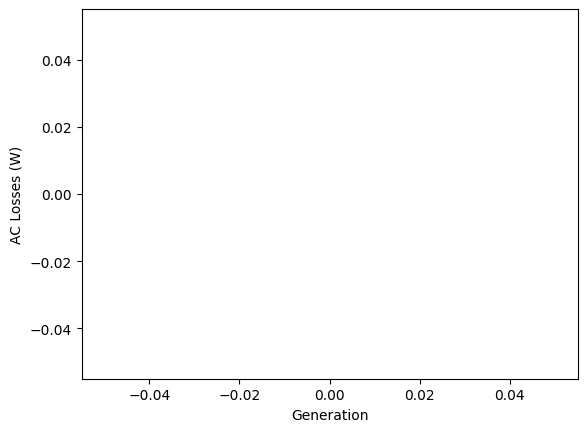

In [ ]:
plt.plot(LossList)
plt.xlabel("Generation")
plt.ylabel("AC Losses (W)")

In [ ]:
for i in range(len(xList)):
    mesh = gen_meshN(xList[i])
    if i==0:
        scene = Draw(materialFunction, mesh, radius=0.02)
    else:
        scene.Redraw(materialFunction, mesh, radius=0.02)
